# EDA

In this Jupyter notebook, we embark on a journey to analyze sentiment in tweets related to Apple and Google products. Our goals are to understand the dataset's structure, clean and preprocess the data, and prepare it for a machine learning model that predicts sentiment based on tweet content. Let's start by loading the dataset and performing an exploratory data analysis (EDA).


In [1]:
#Import the necessary packages
import pandas as pd

## Load and Explore the Dataset
First, we load the dataset to understand its basic structure, including the number of entries, columns, and types of data it contains. This initial exploration is crucial for planning our preprocessing steps.

The dataset contains three columns:
- `tweet_text`: The text of the tweet.
- `emotion_in_tweet_is_directed_at`: The product or brand the tweet is directed at (e.g., iPhone, iPad, Google).
- `is_there_an_emotion_directed_at_a_brand_or_product`: The sentiment of the tweet (e.g., Positive emotion, Negative emotion).



In [2]:
data_path = 'data/judge-1377884607_tweet_product_company.csv'
tweets_df = pd.read_csv(data_path, encoding='ISO-8859-1')
print("Dataset shape:", tweets_df.shape)
print("Data types:\n", tweets_df.dtypes)
tweets_df.head()

Dataset shape: (9093, 3)
Data types:
 tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
tweets_df['tweet_text'].iloc[7483]

'Google maps for mobile 5.2 looks awesome.#sxsw'

In [4]:
original_tweet_7483 = tweets_df.loc[7483, 'tweet_text']
print(original_tweet_7483)

Google maps for mobile 5.2 looks awesome.#sxsw


## Missing Values Analysis
Identifying and handling missing values is crucial since they can significantly impact the performance of our model.

The dataset contains missing values, primarily in the `emotion_in_tweet_is_directed_at` column, with a smaller number in the `tweet_text` column. Since our primary focus is sentiment analysis based on the tweet text, we'll proceed by dropping rows where the tweet text is missing. The `emotion_in_tweet_is_directed_at column` can be ignored for our current purpose, as we are focusing on sentiment, not the specific product mentioned.


In [5]:
missing_values = tweets_df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [6]:
# Remove rows with null values in the 'tweet_text' column in the original DataFrame
tweets_df = tweets_df.dropna(subset=['tweet_text'])

## Sentiment Distribution
Understanding the balance between different sentiment classes helps us gauge the dataset's bias towards certain sentiments. This is important for selecting appropriate modeling and resampling techniques. 

The `is_there_an_emotion_directed_at_a_brand_or_product` column has four unique labels:

- Negative emotion
- Positive emotion
- No emotion toward brand or product
- I can't tell

For the sentiment analysis model, we'll focus on positive and negative emotions. We'll treat "No emotion toward brand or product" and "I can't tell" as neutral or unknown sentiments, which might be excluded from the training to focus the model on distinguishing clearly between positive and negative sentiments.

We have 2,978 positive and 570 negative sentiment tweets. This imbalance in the dataset could influence the performance of our model, making it potentially biased towards predicting positive sentiments. We'll need to keep this in mind during the modeling phase, possibly using techniques like oversampling the minority class, undersampling the majority class, or adjusting the class weights in the model training process to address this imbalance.

In [7]:
sentiment_distribution = tweets_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
print("Sentiment distribution:\n", sentiment_distribution)


Sentiment distribution:
 No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


## Text Length Analysis
Analyzing the length of tweets can reveal insights about the dataset's variability. It helps us decide if we need to normalize text lengths through padding or truncation during preprocessing.


In [8]:
tweets_df['text_length'] = tweets_df['tweet_text'].apply(lambda x: len(str(x)))
tweets_df['text_length'].describe()


count    9092.000000
mean      104.962275
std        27.187640
min        11.000000
25%        86.000000
50%       109.000000
75%       126.000000
max       178.000000
Name: text_length, dtype: float64

## Frequent Words Analysis
Identifying the most frequently occurring words will help us understand common themes and refine our list of stopwords. High-frequency words with little sentiment value might be removed to improve model accuracy.
|

In [9]:
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

all_words = ' '.join(tweets_df['tweet_text'].dropna()).lower()
all_words_tokenized = word_tokenize(all_words)

word_counts = Counter(all_words_tokenized)
word_counts.most_common(20)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('#', 15875),
 ('sxsw', 9516),
 ('@', 7194),
 ('mention', 7124),
 ('.', 5506),
 ('the', 4424),
 ('link', 4313),
 ('}', 4298),
 ('{', 4296),
 ('to', 3586),
 (',', 3533),
 ('at', 3102),
 ('rt', 2962),
 (';', 2800),
 ('&', 2707),
 ('google', 2595),
 ('for', 2545),
 ('ipad', 2446),
 ('!', 2398),
 ('a', 2312)]

## Special Characters and URLs Analysis
Tweets often contain special characters, emojis, and URLs that may not contribute to sentiment analysis. Deciding whether to keep or remove these can impact preprocessing steps and ultimately model performance.


In [10]:
import re

special_chars = tweets_df['tweet_text'].apply(lambda x: re.findall(r'[^\w\s]', str(x)))
special_chars_counts = Counter([item for sublist in special_chars for item in sublist])
print("Special characters counts:", special_chars_counts.most_common(10))

urls_counts = tweets_df['tweet_text'].apply(lambda x: len(re.findall(r"http\S+|www\S+|https\S+", str(x)))).sum()
print("Number of URLs:", urls_counts)


Special characters counts: [('#', 15875), ('.', 8382), ('@', 7194), ('}', 4298), ('{', 4296), (',', 3558), ("'", 2903), (';', 2800), ('&', 2707), ('-', 2438)]
Number of URLs: 44


# Preprocessing


## Encoding Sentiment Labels
For our model to understand the sentiment labels, we need to encode them into a numerical format. In our case, we'll encode positive sentiment as 1 and negative sentiment as 0. This step is crucial for the subsequent modeling process.


In [11]:
sentiment_mapping = {
    'Positive emotion': 1,
    'Negative emotion': 0
}

# Update the mapping based on your dataset's sentiment labels
tweets_df['sentiment_label'] = tweets_df['is_there_an_emotion_directed_at_a_brand_or_product'].map(sentiment_mapping)


In [12]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          9092 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object 
 3   text_length                                         9092 non-null   int64  
 4   sentiment_label                                     3548 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 426.2+ KB


## Handling Missing Values
After cleaning the text, we need to address missing values. Missing sentiment labels or texts could mislead our model training. Depending on the context, we might choose to fill them with a placeholder value or remove those entries.


In [13]:
# Dropping rows with any missing sentiment labels or cleaned tweets
tweets_df = tweets_df.dropna(subset=['sentiment_label'])
tweets_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 9088
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          3548 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3191 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  3548 non-null   object 
 3   text_length                                         3548 non-null   int64  
 4   sentiment_label                                     3548 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 166.3+ KB


# Splitting the Data
Before training our model, we'll split the dataset into training and testing sets. This allows us to train our model on one subset of the data and then test its performance on unseen data, providing a better evaluation of its real-world performance.


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    tweets_df['tweet_text'],
    tweets_df['sentiment_label'],
    stratify=tweets_df['sentiment_label'],
    test_size=0.25, 
    random_state=42
)


## Cleaning the Text Data (BorA TTSplit?)
The next step in our preprocessing is to clean the text data. This involves removing URLs, mentions, special characters, and numbers. These elements are generally not useful for sentiment analysis and can introduce noise into our model. Cleaning helps in focusing on the meaningful content of the tweets.


In [15]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')

def clean_tweet(tweet):
   # Lowercase the text
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Remove the word link
    tweet = re.sub(r'\blink\b', '', tweet)
    
     # Remove mentions
    tweet = re.sub(r'@\w+\b', '', tweet) 
    
    # Remove mentions
    tweet = re.sub(r'\bmention\b', '', tweet)

    # Remove sxsw
    tweet = re.sub(r'\bsxsw\b', '', tweet)

    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    
    # Remove "RT"
    tweet = re.sub(r'\brt\b', '', tweet, flags=re.IGNORECASE)
    
    # Tokenization
    tokens = word_tokenize(tweet)
    
     # Remove stopwords and unnecessary white spaces
    stop_words = set(stopwords.words('english'))
    tokens = [word.strip() for word in tokens if word not in stop_words]
    
    # Lemmatization (optional)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove numeric characters
    tokens = [word for word in tokens if not word.isdigit()]
    
    # Join tokens back into a string
    clean_tweet = ' '.join(tokens).strip()
    
    return clean_tweet
X_train = X_train.apply(clean_tweet)
X_test = X_test.apply(clean_tweet)
X_train.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


692     first ipad didnt even exist last year already ...
3060    thats awesome rumor apple opening temporary st...
2088    charge iphone every 6hours running lowest poss...
4998    really cool stop let u make custom iphone case...
5931    google marissa mayer locationbased fast fun fu...
Name: tweet_text, dtype: object

In [16]:
# import re

# def clean_tweet(tweet):
#     tweet = str(tweet).lower() #Lower case everything
#     tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)  # Remove URLs
#     tweet = re.sub(r'\@\w+|\#', '', tweet)  # Remove mentions and keep hashtags
#     tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
#     tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
#     return tweet

# # tweets_df['cleaned_tweet_text'] = tweets_df['tweet_text'].apply(clean_tweet)

# X_train = X_train.apply(clean_tweet)
# X_test = X_test.apply(clean_tweet)


# # def preprocess_text(text):
# #     # Tokenize text
# #     tokens = word_tokenize(text)
# #     # Remove punctuation
# #     tokens = [token for token in tokens if token not in string.punctuation]
# #     # Convert tokens to lowercase
# #     tokens = [token.lower() for token in tokens]
# #     # Lemmatize tokens
# #     tokens = [lemmatizer.lemmatize(token) for token in tokens]
# #     # Remove stop words
# #     stop_words = set(stopwords.words('english'))
# #     tokens = [token for token in tokens if token not in stop_words]
# #     # Join tokens back into a single string
# #     preprocessed_text = ' '.join(tokens)
# #     return preprocessed_text


In [17]:
X_train.head()

692     first ipad didnt even exist last year already ...
3060    thats awesome rumor apple opening temporary st...
2088    charge iphone every 6hours running lowest poss...
4998    really cool stop let u make custom iphone case...
5931    google marissa mayer locationbased fast fun fu...
Name: tweet_text, dtype: object

## Leminization (BorA TTSplit?)

In [18]:
# from nltk.stem import WordNetLemmatizer
# # Lemmatization function
# lemmatizer = WordNetLemmatizer()
# def lemmatize_text(text):
#     return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# # Apply cleaning and lemmatization
# X_train = X_train.apply(lemmatize_text)
# X_test = X_test.apply(lemmatize_text)

# # Or 

# # tweets_df['cleaned_tweet_text'] = tweets_df['tweet_text'].apply(lemmatize_text)

In [19]:
# Access the first tweet in the X_train Series
first_tweet = X_train.iloc[3]

# Split the tweet into tokens
tokens = first_tweet.split()

# Print the tokens
print(tokens)


['really', 'cool', 'stop', 'let', 'u', 'make', 'custom', 'iphone', 'case', 'zazzlesxsw', 'sxswi']


## Text Vectorization (TF-IDF) (BorA TTSplit?)
Machine Learning models require numerical input, so we convert our cleaned text data into a numerical format using TF-IDF (Term Frequency-Inverse Document Frequency). This technique reflects how important a word is to a document in a collection, helping us to weigh the terms accordingly.


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

# tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=10000)
# X_tfidf = tfidf_vectorizer.fit_transform(tweets_df['cleaned_tweet_text'])

# or
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=10000, )
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Handling Class Imbalance
Our EDA revealed a class imbalance in the sentiment labels. To address this, we can use oversampling for the minority class to help in preventing our model from being biased towards the more frequent class.


In [21]:
from imblearn.over_sampling import RandomOverSampler

#Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

#Resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)

# Check the balance of the resampled data
resampled_balance = pd.Series(y_train_resampled).value_counts()

X_train_resampled.shape, resampled_balance

((4468, 5028),
 1.0    2234
 0.0    2234
 Name: sentiment_label, dtype: int64)

In [22]:
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline


# Assuming you've already defined your X (features) and y (target) from the cleaned data

# List to keep track of model performance
model_performance = []

# Function to evaluate a model and add its performance to our list
def evaluate_model(model, model_name, X, y, cv=5):
    scores = cross_validate(model, X, y, cv=cv, scoring='accuracy', return_train_score = True)
    model_performance.append({
        'Model': model_name,
        'CV Train Accuracy Mean': np.mean(scores['train_score']),
        'CV Test Accuracy Mean': np.mean(scores['test_score']),
        'CV Test Accuracy Std': np.std(scores['test_score'])
    })

# Example models to evaluate
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


# Define pipelines for different models
nb_pipeline = Pipeline([('clf', MultinomialNB())])
lr_pipeline = Pipeline([('clf', LogisticRegression(random_state=42))])
rf_pipeline = Pipeline([('clf', RandomForestClassifier(random_state=42))])
ada_pipeline = Pipeline([('clf', AdaBoostClassifier(random_state=42))])
xgb_pipeline = Pipeline([('clf', XGBClassifier(random_state=42))])
knn_pipeline = Pipeline([('clf', KNeighborsClassifier())])

# Evaluate models
evaluate_model(nb_pipeline, 'Multinomial Naive Bayes', X_train_resampled, y_train_resampled)
evaluate_model(lr_pipeline, 'Logistic Regression', X_train_resampled, y_train_resampled)
evaluate_model(rf_pipeline, 'Random Forest', X_train_resampled, y_train_resampled)
evaluate_model(ada_pipeline, 'AdaBoost', X_train_resampled, y_train_resampled)
evaluate_model(xgb_pipeline, 'XGBoost', X_train_resampled, y_train_resampled)
evaluate_model(knn_pipeline, 'K-Nearest Neighbors', X_train_resampled, y_train_resampled)


# Convert the performance list to a DataFrame
performance_df = pd.DataFrame(model_performance)

# Display the performance DataFrame
print(performance_df)

                     Model  CV Train Accuracy Mean  CV Test Accuracy Mean  \
0  Multinomial Naive Bayes                0.960441               0.913166   
1      Logistic Regression                0.967547               0.930174   
2            Random Forest                0.998657               0.977397   
3                 AdaBoost                0.774284               0.745079   
4                  XGBoost                0.967435               0.915177   
5      K-Nearest Neighbors                0.917917               0.868843   

   CV Test Accuracy Std  
0              0.011753  
1              0.009298  
2              0.003827  
3              0.007422  
4              0.005507  
5              0.011634  


In [23]:
from sklearn.metrics import accuracy_score

# Train the Random Forest pipeline on the entire training dataset
nb_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set using the Random Forest pipeline
y_pred_test = nb_pipeline.predict(X_test_tfidf)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8523111612175873


In [24]:
from sklearn.metrics import accuracy_score

# Train the Random Forest pipeline on the entire training dataset
lr_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set using the Random Forest pipeline
y_pred_test = lr_pipeline.predict(X_test_tfidf)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8523111612175873


In [25]:
from sklearn.metrics import accuracy_score

# Train the Random Forest pipeline on the entire training dataset
rf_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set using the Random Forest pipeline
y_pred_test = rf_pipeline.predict(X_test_tfidf)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8658399098083427


In [26]:
from sklearn.metrics import accuracy_score

# Train the Random Forest pipeline on the entire training dataset
ada_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set using the Random Forest pipeline
y_pred_test = ada_pipeline.predict(X_test_tfidf)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.644870349492672


In [27]:
from sklearn.metrics import accuracy_score

# Train the Random Forest pipeline on the entire training dataset
xgb_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set using the Random Forest pipeline
y_pred_test = xgb_pipeline.predict(X_test_tfidf)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8139797068771139


In [28]:
from sklearn.metrics import accuracy_score

# Train the Random Forest pipeline on the entire training dataset
knn_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set using the Random Forest pipeline
y_pred_test = knn_pipeline.predict(X_test_tfidf)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.7869222096956031


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters: {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
Best Score: 0.9865724213432336
Accuracy of Best Model: 0.8703494926719278
Classification Report of Best Model:
               precision    recall  f1-score   support

         0.0       0.74      0.30      0.43       143
         1.0       0.88      0.98      0.93       744

    accuracy                           0.87       887
   macro avg       0.81      0.64      0.68       887
weighted avg       0.86      0.87      0.85       887



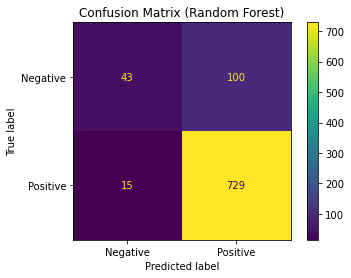

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for Random Forest
param_grid = {
    'clf__n_estimators': [100, 200, 300, 400, 500],
    'clf__min_samples_split': [2, 5, 7, 10],
    'clf__min_samples_leaf': [1, 2, 3, 4, 5],
    'clf__criterion': ['gini', 'entropy']  # Example addition
    }

# Create a GridSearchCV object with the Random Forest pipeline and the parameter grid
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
y_pred_best = best_rf_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best model
print("Accuracy of Best Model:", accuracy_score(y_test, y_pred_best))
print("Classification Report of Best Model:\n", classification_report(y_test, y_pred_best))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for the best Logistic Regression model
disp = ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp.ax_.set_title('Confusion Matrix (Random Forest)')
plt.show()



Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters (Logistic Regression): {'clf__C': 100, 'clf__max_iter': 2000, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Best Score (Logistic Regression): 0.9675487447735431
Accuracy of Best Model (Logistic Regression): 0.8669673055242391
Classification Report of Best Model (Logistic Regression):
               precision    recall  f1-score   support

         0.0       0.61      0.48      0.54       143
         1.0       0.90      0.94      0.92       744

    accuracy                           0.87       887
   macro avg       0.76      0.71      0.73       887
weighted avg       0.86      0.87      0.86       887



C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


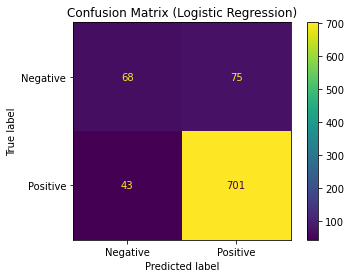

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for Logistic Regression
lr_param_grid = {
'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400],  # Regularization parameter
    'clf__penalty': ['l1', 'l2'],  # Regularization penalty
    'clf__solver': ['liblinear', 'saga'],  # Optimization algorithm
    'clf__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]  # Maximum number of iterations
}

# Create a GridSearchCV object with the Logistic Regression pipeline and the parameter grid
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
lr_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_lr_model = lr_grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters (Logistic Regression):", lr_grid_search.best_params_)
print("Best Score (Logistic Regression):", lr_grid_search.best_score_)

# Predict using the best Logistic Regression model
y_pred_lr_best = best_lr_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best Logistic Regression model
print("Accuracy of Best Model (Logistic Regression):", accuracy_score(y_test, y_pred_lr_best))
print("Classification Report of Best Model (Logistic Regression):\n", classification_report(y_test, y_pred_lr_best))


from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for the best Logistic Regression model
disp = ConfusionMatrixDisplay.from_estimator(best_lr_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp.ax_.set_title('Confusion Matrix (Logistic Regression)')
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (Multinomial Naive Bayes): {'clf__alpha': 0.1, 'clf__fit_prior': True}
Best Score (Multinomial Naive Bayes): 0.9371096597698731
Accuracy of Best Model (Multinomial Naive Bayes): 0.8602029312288614
Classification Report of Best Model (Multinomial Naive Bayes):
               precision    recall  f1-score   support

         0.0       0.57      0.56      0.56       143
         1.0       0.92      0.92      0.92       744

    accuracy                           0.86       887
   macro avg       0.74      0.74      0.74       887
weighted avg       0.86      0.86      0.86       887



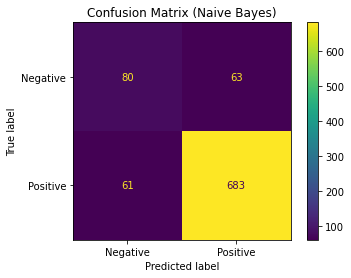

In [31]:
# Define the parameter grid for Multinomial Naive Bayes
nb_param_grid = {
    'clf__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],  # Additive smoothing parameter
    'clf__fit_prior': [True, False] # Whether to learn class prior probabilities
}

# Create a GridSearchCV object with the Multinomial Naive Bayes pipeline and the parameter grid
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
nb_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_nb_model = nb_grid_search.best_estimator_

# Print the best parameters and the best score
print("Best Parameters (Multinomial Naive Bayes):", nb_grid_search.best_params_)
print("Best Score (Multinomial Naive Bayes):", nb_grid_search.best_score_)

# Predict using the best Multinomial Naive Bayes model
y_pred_nb_best = best_nb_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best Multinomial Naive Bayes model
print("Accuracy of Best Model (Multinomial Naive Bayes):", accuracy_score(y_test, y_pred_nb_best))
print("Classification Report of Best Model (Multinomial Naive Bayes):\n", classification_report(y_test, y_pred_nb_best))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for the best Logistic Regression model
disp = ConfusionMatrixDisplay.from_estimator(best_nb_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp.ax_.set_title('Confusion Matrix (Naive Bayes)')
plt.show()



Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters (AdaBoost): {'clf__algorithm': 'SAMME.R', 'clf__learning_rate': 1.0, 'clf__n_estimators': 200}
Best Score (AdaBoost): 0.8910048575673082
Accuracy of Best Model (AdaBoost): 0.7936865839909808
Classification Report of Best Model (AdaBoost):
               precision    recall  f1-score   support

         0.0       0.39      0.49      0.43       143
         1.0       0.90      0.85      0.87       744

    accuracy                           0.79       887
   macro avg       0.64      0.67      0.65       887
weighted avg       0.81      0.79      0.80       887



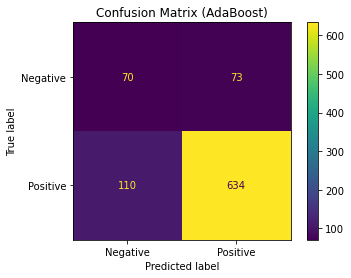

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for AdaBoost
ada_param_grid = {
    'clf__n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],  # Learning rate
    'clf__algorithm': ['SAMME', 'SAMME.R']  # Algorithm for boosting
}

# Create a GridSearchCV object with the AdaBoost pipeline and the parameter grid
ada_grid_search = GridSearchCV(ada_pipeline, ada_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
ada_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_ada_model = ada_grid_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters (AdaBoost):", ada_grid_search.best_params_)
print("Best Score (AdaBoost):", ada_grid_search.best_score_)

# Predict using the best AdaBoost model
y_pred_ada_best = best_ada_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best AdaBoost model
print("Accuracy of Best Model (AdaBoost):", accuracy_score(y_test, y_pred_ada_best))
print("Classification Report of Best Model (AdaBoost):\n", classification_report(y_test, y_pred_ada_best))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for the best AdaBoost model
disp_ada = ConfusionMatrixDisplay.from_estimator(best_ada_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp_ada.ax_.set_title('Confusion Matrix (AdaBoost)')
plt.show()


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters (XGBoost): {'clf__learning_rate': 1.0, 'clf__max_depth': 6, 'clf__min_child_weight': 1, 'clf__n_estimators': 200}
Best Score (XGBoost): 0.9552362270806245
Accuracy of Best Model (XGBoost): 0.846674182638106
Classification Report of Best Model (XGBoost):
               precision    recall  f1-score   support

         0.0       0.53      0.39      0.45       143
         1.0       0.89      0.93      0.91       744

    accuracy                           0.85       887
   macro avg       0.71      0.66      0.68       887
weighted avg       0.83      0.85      0.84       887



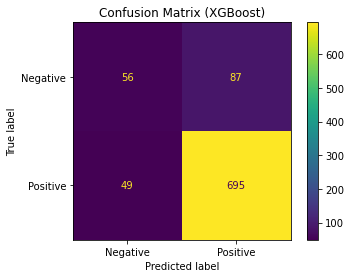

In [33]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'clf__n_estimators': [50, 100, 150, 200],  # Number of boosting rounds
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],  # Step size shrinkage used in update
    'clf__max_depth': [3, 4, 5, 6],  # Maximum depth of a tree
    'clf__min_child_weight': [1, 2, 3]  # Minimum sum of instance weight (hessian) needed in a child
}

# Create a GridSearchCV object with the XGBoost pipeline and the parameter grid
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
xgb_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_xgb_model = xgb_grid_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters (XGBoost):", xgb_grid_search.best_params_)
print("Best Score (XGBoost):", xgb_grid_search.best_score_)

# Predict using the best XGBoost model
y_pred_xgb_best = best_xgb_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best XGBoost model
print("Accuracy of Best Model (XGBoost):", accuracy_score(y_test, y_pred_xgb_best))
print("Classification Report of Best Model (XGBoost):\n", classification_report(y_test, y_pred_xgb_best))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for the best XGBoost model
disp_xgb = ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp_xgb.ax_.set_title('Confusion Matrix (XGBoost)')
plt.show()


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters (KNN): {'clf__algorithm': 'auto', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best Score (KNN): 0.930171781016156
Accuracy of Best Model (KNN): 0.8410372040586246
Classification Report of Best Model (KNN):
               precision    recall  f1-score   support

         0.0       0.51      0.50      0.51       143
         1.0       0.90      0.91      0.91       744

    accuracy                           0.84       887
   macro avg       0.71      0.70      0.71       887
weighted avg       0.84      0.84      0.84       887



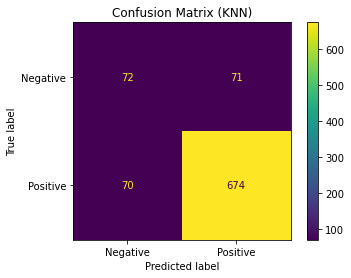

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for KNN
knn_param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'clf__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
}

# Create a GridSearchCV object with the KNN pipeline and the parameter grid
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to your data
knn_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_knn_model = knn_grid_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters (KNN):", knn_grid_search.best_params_)
print("Best Score (KNN):", knn_grid_search.best_score_)

# Predict using the best KNN model
y_pred_knn_best = best_knn_model.predict(X_test_tfidf)  # Make sure to transform your test set features as needed

# Evaluate the best KNN model
print("Accuracy of Best Model (KNN):", accuracy_score(y_test, y_pred_knn_best))
print("Classification Report of Best Model (KNN):\n", classification_report(y_test, y_pred_knn_best))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for the best KNN model
disp_knn = ConfusionMatrixDisplay.from_estimator(best_knn_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'])
disp_knn.ax_.set_title('Confusion Matrix (KNN)')
plt.show()


Ensemble Model Evaluation:
Accuracy: 0.8816234498308907
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.43      0.54       143
         1.0       0.90      0.97      0.93       744

    accuracy                           0.88       887
   macro avg       0.81      0.70      0.74       887
weighted avg       0.87      0.88      0.87       887



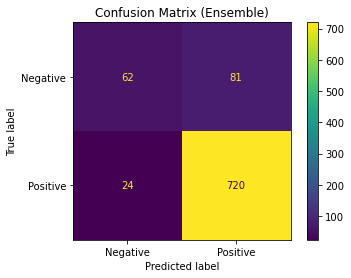

In [35]:
# Assuming you have obtained the best models from your GridSearchCVs
best_models = [best_lr_model, best_nb_model, best_rf_model, best_xgb_model]  # List of best models

# Get predictions from all best models
predictions = []
for model in best_models:
    predictions.append(model.predict_proba(X_test_tfidf))

# Calculate weighted average of predicted probabilities
# You can assign equal weights to all models for simplicity
weights = [1 / len(best_models)] * len(best_models)
weighted_probs = np.average(predictions, axis=0, weights=weights)

# Make final prediction based on the highest combined probability
final_prediction = np.argmax(weighted_probs, axis=1)

# Optionally, you can also use the predicted probabilities or ensemble model for evaluation
from sklearn.metrics import classification_report, accuracy_score

# # Optionally, evaluate each individual model
# for i, model in enumerate(best_models):
#     y_pred = model.predict(X_test_tfidf)
#     print(f"Model {i+1} Evaluation:")
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))

# Evaluate the ensemble model
print("Ensemble Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, final_prediction))
print("Classification Report:")
print(classification_report(y_test, final_prediction))

# Plot confusion matrix for the ensemble model
disp_ensemble = ConfusionMatrixDisplay.from_predictions(y_test, final_prediction, display_labels=['Negative', 'Positive'])
disp_ensemble.ax_.set_title('Confusion Matrix (Ensemble)')
plt.show()

In [36]:
weighted_probs

array([[0.05031659, 0.94968341],
       [0.13432547, 0.86567453],
       [0.01633047, 0.98366953],
       ...,
       [0.04098415, 0.95901585],
       [0.98843662, 0.01156338],
       [0.01486877, 0.98513123]])

In [37]:
weights

[0.25, 0.25, 0.25, 0.25]

C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn

Stacking Classifier Evaluation:
Accuracy: 0.8793686583990981
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.28      0.43       143
         1.0       0.88      0.99      0.93       744

    accuracy                           0.88       887
   macro avg       0.89      0.64      0.68       887
weighted avg       0.88      0.88      0.85       887



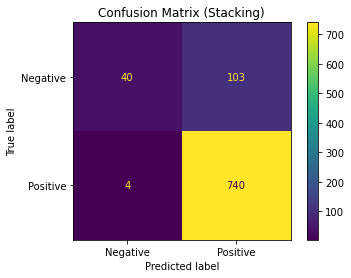

In [38]:
from sklearn.ensemble import StackingClassifier

# Define the meta model for stacking
meta_model = LogisticRegression(random_state=42)

# Create the stacking classifier with base models and meta model
stacking_clf = StackingClassifier(estimators=[('lr', best_lr_model), ('nb', best_nb_model), ('rf', best_rf_model), ('xgb', best_xgb_model)],
                                   final_estimator=meta_model)

# Fit the stacking classifier on the training data
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
stacking_pred = stacking_clf.predict(X_test_tfidf)

# Evaluate the stacking classifier
print("Stacking Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, stacking_pred))
print("Classification Report:")
print(classification_report(y_test, stacking_pred))

# Plot confusion matrix for the stacking classifier
disp_stacking = ConfusionMatrixDisplay.from_predictions(y_test, stacking_pred, display_labels=['Negative', 'Positive'])
disp_stacking.ax_.set_title('Confusion Matrix (Stacking)')
plt.show()


C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn

Stacking Classifier Evaluation:
Accuracy: 0.8771138669673055
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.25      0.40       143
         1.0       0.87      1.00      0.93       744

    accuracy                           0.88       887
   macro avg       0.91      0.62      0.66       887
weighted avg       0.89      0.88      0.85       887



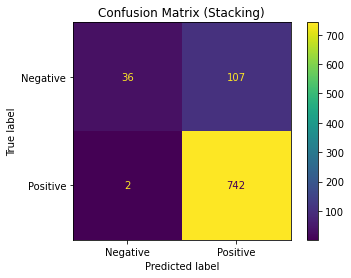

In [39]:
from sklearn.ensemble import StackingClassifier

# Define the meta model for stacking
meta_model = RandomForestClassifier(random_state=42)

# Create the stacking classifier with base models and meta model
stacking_clf = StackingClassifier(estimators=[('lr', best_lr_model), ('nb', best_nb_model), 
                                              ('rf', best_rf_model), ('xgb', best_xgb_model)],
                                   final_estimator=meta_model)

# Fit the stacking classifier on the training data
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
stacking_pred = stacking_clf.predict(X_test_tfidf)

# Evaluate the stacking classifier
print("Stacking Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, stacking_pred))
print("Classification Report:")
print(classification_report(y_test, stacking_pred))

# Plot confusion matrix for the stacking classifier
disp_stacking = ConfusionMatrixDisplay.from_predictions(y_test, stacking_pred, display_labels=['Negative', 'Positive'])
disp_stacking.ax_.set_title('Confusion Matrix (Stacking)')
plt.show()


C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn

Stacking Classifier Evaluation:
Accuracy: 0.8613303269447576
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.30      0.41       143
         1.0       0.88      0.97      0.92       744

    accuracy                           0.86       887
   macro avg       0.76      0.63      0.67       887
weighted avg       0.84      0.86      0.84       887



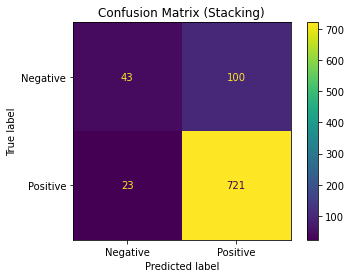

In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

# Define the meta model for stacking
meta_model = ComplementNB()

# Create the stacking classifier with base models and meta model
stacking_clf = StackingClassifier(estimators=[('lr', best_lr_model), ('nb', best_nb_model), 
                                              ('rf', best_rf_model), ('xgb', best_xgb_model)],
                                   final_estimator=meta_model)

# Fit the stacking classifier on the training data
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
stacking_pred = stacking_clf.predict(X_test_tfidf)

# Evaluate the stacking classifier
print("Stacking Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, stacking_pred))
print("Classification Report:")
print(classification_report(y_test, stacking_pred))

# Plot confusion matrix for the stacking classifier
disp_stacking = ConfusionMatrixDisplay.from_predictions(y_test, stacking_pred, display_labels=['Negative', 'Positive'])
disp_stacking.ax_.set_title('Confusion Matrix (Stacking)')
plt.show()


C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\johns\anaconda3\envs\learn

Stacking Classifier Evaluation:
Accuracy: 0.8782412626832018
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.26      0.41       143
         1.0       0.88      1.00      0.93       744

    accuracy                           0.88       887
   macro avg       0.91      0.63      0.67       887
weighted avg       0.89      0.88      0.85       887



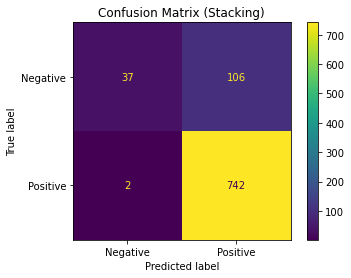

In [41]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

# Define the meta model for stacking
meta_model = best_lr_model

# Create the stacking classifier with base models and meta model
stacking_clf = StackingClassifier(estimators=[('lr', best_lr_model), ('nb', best_nb_model), 
                                              ('rf', best_rf_model)],
                                   final_estimator=meta_model)

# Fit the stacking classifier on the training data
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
stacking_pred = stacking_clf.predict(X_test_tfidf)

# Evaluate the stacking classifier
print("Stacking Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, stacking_pred))
print("Classification Report:")
print(classification_report(y_test, stacking_pred))

# Plot confusion matrix for the stacking classifier
disp_stacking = ConfusionMatrixDisplay.from_predictions(y_test, stacking_pred, display_labels=['Negative', 'Positive'])
disp_stacking.ax_.set_title('Confusion Matrix (Stacking)')
plt.show()


C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Hard Voting): 0.874859075535513
Classification Report (Hard Voting):
               precision    recall  f1-score   support

         0.0       0.65      0.49      0.56       143
         1.0       0.91      0.95      0.93       744

    accuracy                           0.87       887
   macro avg       0.78      0.72      0.74       887
weighted avg       0.86      0.87      0.87       887



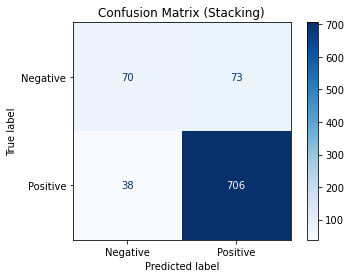

In [42]:
from sklearn.ensemble import VotingClassifier

# Assuming you have obtained the best models from your GridSearchCVs
best_models = [best_lr_model, best_nb_model, best_rf_model, best_xgb_model]  # List of best models

# Create the VotingClassifier with hard voting
voting_hard = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model),
                                          ('knn', best_knn_model),
                                          ('ada', best_ada_model),
                                          ('xgb', best_xgb_model)],
                                voting='hard')

# Fit the ensemble model
voting_hard.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_hard = voting_hard.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Hard Voting):", accuracy_score(y_test, y_pred_hard))
print("Classification Report (Hard Voting):\n", classification_report(y_test, y_pred_hard))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_hard)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()



C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Soft Voting): 0.882750845546787
Classification Report (Soft Voting):
               precision    recall  f1-score   support

         0.0       0.73      0.43      0.54       143
         1.0       0.90      0.97      0.93       744

    accuracy                           0.88       887
   macro avg       0.81      0.70      0.74       887
weighted avg       0.87      0.88      0.87       887



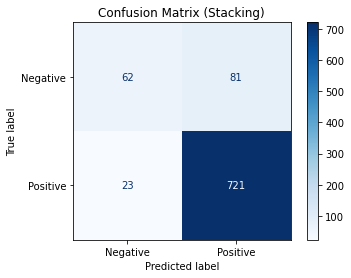

In [43]:
# Create the VotingClassifier with soft voting
voting_soft = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model), 
                                          ('knn', best_knn_model),
                                           ('ada', best_ada_model),
                                          ('xgb', best_xgb_model)],
                                voting='soft')

# Fit the ensemble model
voting_soft.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_soft = voting_soft.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Soft Voting):", accuracy_score(y_test, y_pred_soft))
print("Classification Report (Soft Voting):\n", classification_report(y_test, y_pred_soft))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_soft)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()



# The best model so far! .9014

# Hard Voting

In hard voting, each individual model in the ensemble makes a prediction, and the final prediction is determined by majority voting.

C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Hard Voting): 0.8816234498308907
Classification Report (Hard Voting):
               precision    recall  f1-score   support

         0.0       0.72      0.43      0.54       143
         1.0       0.90      0.97      0.93       744

    accuracy                           0.88       887
   macro avg       0.81      0.70      0.74       887
weighted avg       0.87      0.88      0.87       887



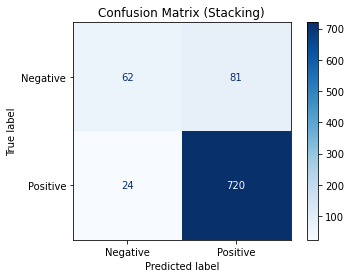

In [44]:
from sklearn.ensemble import VotingClassifier

# Assuming you have obtained the best models from your GridSearchCVs
best_models = [best_lr_model, best_nb_model, best_rf_model, best_xgb_model]  # List of best models

# Create the VotingClassifier with hard voting
voting_hard = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model)],
                                voting='hard')

# Fit the ensemble model
voting_hard.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_hard = voting_hard.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Hard Voting):", accuracy_score(y_test, y_pred_hard))
print("Classification Report (Hard Voting):\n", classification_report(y_test, y_pred_hard))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_hard)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()


C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Hard Voting): 0.874859075535513
Classification Report (Hard Voting):
               precision    recall  f1-score   support

         0.0       0.64      0.51      0.57       143
         1.0       0.91      0.94      0.93       744

    accuracy                           0.87       887
   macro avg       0.77      0.73      0.75       887
weighted avg       0.87      0.87      0.87       887



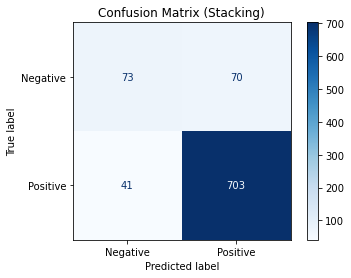

In [45]:
from sklearn.ensemble import VotingClassifier

# Assuming you have obtained the best models from your GridSearchCVs
best_models = [best_lr_model, best_nb_model, best_rf_model, best_xgb_model]  # List of best models

# Create the VotingClassifier with hard voting
voting_hard = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model),
                                          ('knn', best_knn_model)],
                                voting='hard')

# Fit the ensemble model
voting_hard.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_hard = voting_hard.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Hard Voting):", accuracy_score(y_test, y_pred_hard))
print("Classification Report (Hard Voting):\n", classification_report(y_test, y_pred_hard))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_hard)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()


C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Hard Voting): 0.874859075535513
Classification Report (Hard Voting):
               precision    recall  f1-score   support

         0.0       0.64      0.51      0.57       143
         1.0       0.91      0.94      0.93       744

    accuracy                           0.87       887
   macro avg       0.77      0.73      0.75       887
weighted avg       0.87      0.87      0.87       887



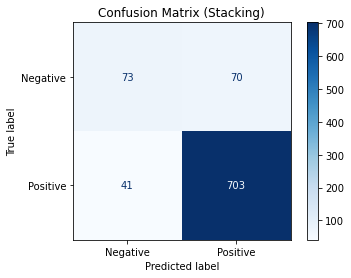

In [46]:
from sklearn.ensemble import VotingClassifier

# Assuming you have obtained the best models from your GridSearchCVs
best_models = [best_lr_model, best_nb_model, best_rf_model, best_xgb_model]  # List of best models

# Create the VotingClassifier with hard voting
voting_hard = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model),
                                          ('knn', best_knn_model)],
                                voting='hard')

# Fit the ensemble model
voting_hard.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_hard = voting_hard.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Hard Voting):", accuracy_score(y_test, y_pred_hard))
print("Classification Report (Hard Voting):\n", classification_report(y_test, y_pred_hard))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_hard)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()


C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Hard Voting): 0.8714768883878241
Classification Report (Hard Voting):
               precision    recall  f1-score   support

         0.0       0.64      0.47      0.54       143
         1.0       0.90      0.95      0.93       744

    accuracy                           0.87       887
   macro avg       0.77      0.71      0.73       887
weighted avg       0.86      0.87      0.86       887



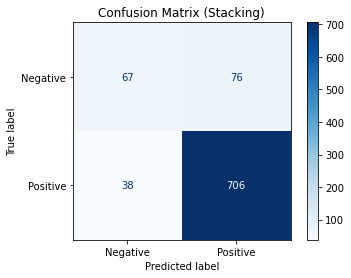

In [47]:
from sklearn.ensemble import VotingClassifier

# Assuming you have obtained the best models from your GridSearchCVs
best_models = [best_lr_model, best_nb_model, best_rf_model, best_xgb_model]  # List of best models

# Create the VotingClassifier with hard voting
voting_hard = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model),
                                          
                                          ('xgb', best_xgb_model)],
                                voting='hard')

# Fit the ensemble model
voting_hard.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_hard = voting_hard.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Hard Voting):", accuracy_score(y_test, y_pred_hard))
print("Classification Report (Hard Voting):\n", classification_report(y_test, y_pred_hard))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_hard)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()


# Soft Voting
In soft voting, each individual model predicts the probabilities for each class, and the final prediction is determined by averaging these probabilities and selecting the class with the highest average probability.

C:\Users\johns\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy (Soft Voting): 0.8782412626832018
Classification Report (Soft Voting):
               precision    recall  f1-score   support

         0.0       0.68      0.45      0.55       143
         1.0       0.90      0.96      0.93       744

    accuracy                           0.88       887
   macro avg       0.79      0.71      0.74       887
weighted avg       0.87      0.88      0.87       887



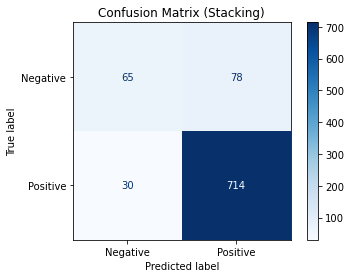

In [48]:
# Create the VotingClassifier with soft voting
voting_soft = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model)],
                                voting='soft')

# Fit the ensemble model
voting_soft.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_soft = voting_soft.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Soft Voting):", accuracy_score(y_test, y_pred_soft))
print("Classification Report (Soft Voting):\n", classification_report(y_test, y_pred_soft))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_soft)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()



In [ ]:
# Create the VotingClassifier with soft voting
voting_soft = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model),
                                          ('knn', best_knn_model)],
                                voting='soft')

# Fit the ensemble model
voting_soft.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_soft = voting_soft.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Soft Voting):", accuracy_score(y_test, y_pred_soft))
print("Classification Report (Soft Voting):\n", classification_report(y_test, y_pred_soft))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_soft)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()



In [ ]:
# Create the VotingClassifier with soft voting
voting_soft = VotingClassifier(estimators=[('lr', best_lr_model), 
                                           ('nb', best_nb_model), 
                                           ('rf', best_rf_model),
                                          
                                          ('xgb', best_xgb_model)],
                                voting='soft')

# Fit the ensemble model
voting_soft.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_soft = voting_soft.predict(X_test_tfidf)

# Evaluate the ensemble model
print("Accuracy (Soft Voting):", accuracy_score(y_test, y_pred_soft))
print("Classification Report (Soft Voting):\n", classification_report(y_test, y_pred_soft))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_soft)

# Plot confusion matrix
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_stacking, display_labels=['Negative', 'Positive'])
disp_stacking.plot(cmap='Blues')
plt.title('Confusion Matrix (Stacking)')
plt.show()
